<a href="https://colab.research.google.com/github/Mayo-27-git/Major-Project/blob/main/PIX2PIX_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/FINAL PROJECT'  # Change this to your dataset path
image_dir = os.path.join(data_dir, 'REAL IMAGES')
mask_dir = os.path.join(data_dir, 'NVIDIA MASKS')
output_dir = os.path.join(data_dir, 'masked_images')

In [ ]:
# Create output directory
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Get sorted lists of images and masks
image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))
print(len(image_files))
print(len(mask_files))

3000
3000


In [ ]:
# Ensure both lists have the same number of files
assert len(image_files) == len(mask_files), "Mismatch in number of images and masks."

In [ ]:
# Apply each mask to the corresponding image
for img_name, mask_name in zip(image_files, mask_files):
    # Load image and mask
    img = cv2.imread(os.path.join(image_dir, img_name))
    mask = cv2.imread(os.path.join(mask_dir, mask_name), cv2.IMREAD_GRAYSCALE)

    # Resize mask to match image size
    mask = cv2.resize(mask, (img.shape[1], img.shape[0]))

    # Convert mask to binary (1 for missing pixels, 0 for kept pixels)
    mask = mask / 255
    mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

    # Apply mask to image (blackout masked areas)
    masked_img = img * (1 - mask)

    # Save the masked image
    cv2.imwrite(os.path.join(output_dir, img_name), masked_img)

print("✅ Masks applied successfully! Masked images are saved in 'masked_images' folder.")

✅ Masks applied successfully! Masked images are saved in 'masked_images' folder.


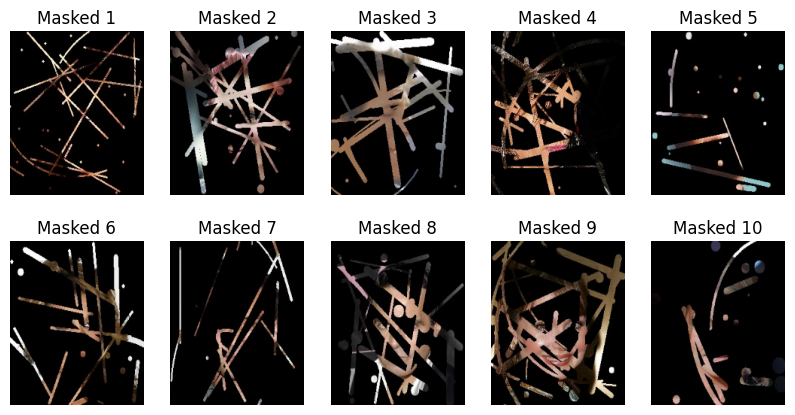

In [ ]:
# Display some masked images
masked_files = sorted(os.listdir(output_dir))
plt.figure(figsize=(10, 5))
for i, masked_img_name in enumerate(masked_files[:10]):  # Show first 5 images
    img = cv2.imread(os.path.join(output_dir, masked_img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Masked {i+1}")
plt.show()


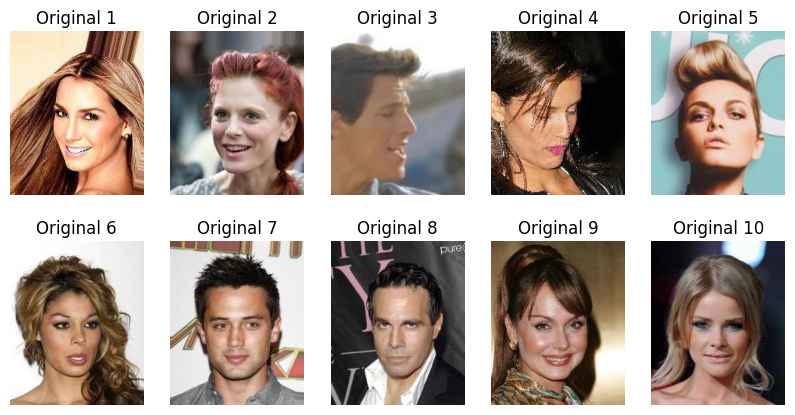

In [ ]:
# Load and display original images
plt.figure(figsize=(10, 5))
for i, original_img_name in enumerate(image_files[:10]):  # Show first 5 images
    img = cv2.imread(os.path.join(image_dir, original_img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Original {i+1}")
plt.show()


In [ ]:
!pip install torch torchvision matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class Pix2PixDataset(Dataset):
    def __init__(self, masked_dir, original_dir, transform=None):
        self.masked_images = sorted(os.listdir(masked_dir))
        self.original_images = sorted(os.listdir(original_dir))
        self.masked_dir = masked_dir
        self.original_dir = original_dir
        self.transform = transform

    def __len__(self):
        return len(self.masked_images)

    def __getitem__(self, idx):
        masked_path = os.path.join(self.masked_dir, self.masked_images[idx])
        original_path = os.path.join(self.original_dir, self.original_images[idx])

        # Load images
        masked_img = cv2.imread(masked_path)
        original_img = cv2.imread(original_path)

        # Convert to RGB
        masked_img = cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB)
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

        # Convert to tensors and normalize to [-1, 1]
        if self.transform:
            masked_img = self.transform(masked_img)
            original_img = self.transform(original_img)

        return masked_img, original_img

# Define transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

# Load dataset
masked_dir = "/content/drive/MyDrive/FINAL PROJECT/masked_images"
original_dir = "/content/drive/MyDrive/FINAL PROJECT/REAL IMAGES"
dataset = Pix2PixDataset(masked_dir, original_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


In [ ]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def down_block(in_channels, out_channels, normalize=True):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2))
            return nn.Sequential(*layers)

        def up_block(in_channels, out_channels, dropout=False):
            layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                      nn.BatchNorm2d(out_channels),
                      nn.ReLU()]
            if dropout:
                layers.append(nn.Dropout(0.5))
            return nn.Sequential(*layers)

        self.encoder = nn.ModuleList([
            down_block(3, 64, normalize=False),
            down_block(64, 128),
            down_block(128, 256),
            down_block(256, 512),
            down_block(512, 512),
            down_block(512, 512),
            down_block(512, 512),
            down_block(512, 512, normalize=False)
        ])

        self.decoder = nn.ModuleList([
            up_block(512, 512, dropout=True),
            up_block(1024, 512, dropout=True),
            up_block(1024, 512, dropout=True),
            up_block(1024, 512),
            up_block(1024, 256),
            up_block(512, 128),
            up_block(256, 64)
        ])

        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        skips = []
        for layer in self.encoder:
            x = layer(x)
            skips.append(x)

        skips = skips[:-1][::-1]  # Reverse for skip connections

        for i, layer in enumerate(self.decoder):
            x = layer(x)
            x = torch.cat([x, skips[i]], 1)

        return self.final(x)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def block(in_channels, out_channels, normalize=True):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2))
            return nn.Sequential(*layers)

        self.model = nn.Sequential(
            block(6, 64, normalize=False),  # Input: masked image + generated image
            block(64, 128),
            block(128, 256),
            block(256, 512),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


Epoch [1/60]  D Loss: 0.5424  G Loss: 29.6421  L1 Loss: 28.9633  GAN Loss: 0.6788
Epoch [2/60]  D Loss: 0.5219  G Loss: 23.7312  L1 Loss: 23.0427  GAN Loss: 0.6885
Epoch [3/60]  D Loss: 0.5033  G Loss: 22.0377  L1 Loss: 21.3446  GAN Loss: 0.6931
Epoch [4/60]  D Loss: 0.5033  G Loss: 20.9850  L1 Loss: 20.2919  GAN Loss: 0.6931
Epoch [5/60]  D Loss: 0.5032  G Loss: 20.1734  L1 Loss: 19.4803  GAN Loss: 0.6931
Epoch [6/60]  D Loss: 0.5193  G Loss: 19.4127  L1 Loss: 18.7292  GAN Loss: 0.6834
Epoch [7/60]  D Loss: 0.5137  G Loss: 18.8397  L1 Loss: 18.1475  GAN Loss: 0.6922
Epoch [8/60]  D Loss: 0.5170  G Loss: 18.3544  L1 Loss: 17.6618  GAN Loss: 0.6925
Epoch [9/60]  D Loss: 0.5079  G Loss: 17.7932  L1 Loss: 17.1014  GAN Loss: 0.6918
Epoch [10/60]  D Loss: 0.5032  G Loss: 17.4612  L1 Loss: 16.7681  GAN Loss: 0.6931
Epoch [11/60]  D Loss: 0.5033  G Loss: 16.9848  L1 Loss: 16.2916  GAN Loss: 0.6931
Epoch [12/60]  D Loss: 0.5033  G Loss: 16.6483  L1 Loss: 15.9552  GAN Loss: 0.6931
Epoch [13/60]

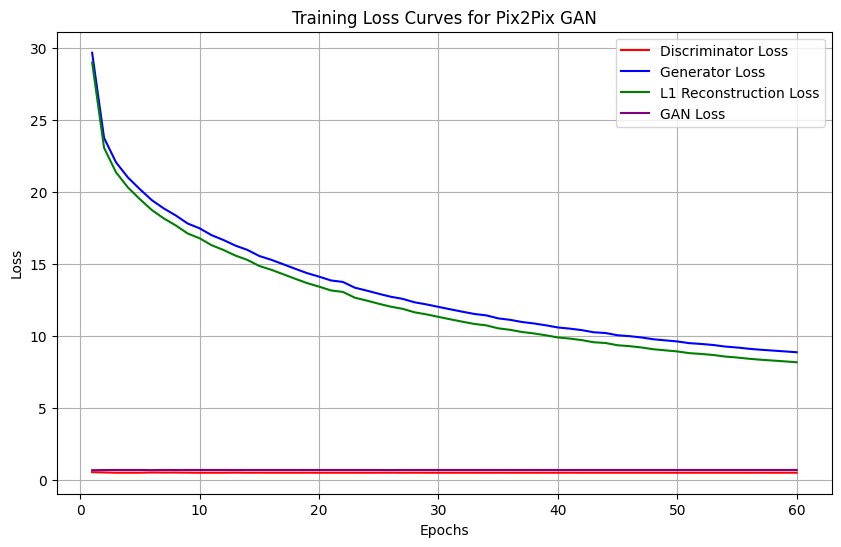

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, optimizers, and loss functions
generator = Generator().to(device)  # Define your generator model
discriminator = Discriminator().to(device)  # Define your discriminator model

criterion_GAN = nn.BCEWithLogitsLoss()  # Adversarial loss
criterion_L1 = nn.L1Loss()  # L1 loss for reconstruction

optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

num_epochs = 60
d_losses, g_losses, l1_losses, gan_losses = [], [], [], []

for epoch in range(num_epochs):
    epoch_d_loss, epoch_g_loss, epoch_l1_loss, epoch_gan_loss = 0, 0, 0, 0
    num_batches = len(dataloader)

    for i, (masked_imgs, real_imgs) in enumerate(dataloader):
        masked_imgs, real_imgs = masked_imgs.to(device), real_imgs.to(device)

        # ---- Train Discriminator ----
        optimizer_D.zero_grad()

        real_preds = discriminator(torch.cat((masked_imgs, real_imgs), 1))
        fake_imgs = generator(masked_imgs)
        fake_preds = discriminator(torch.cat((masked_imgs, fake_imgs.detach()), 1))

        real_labels = torch.ones_like(real_preds)
        fake_labels = torch.zeros_like(fake_preds)

        d_real_loss = criterion_GAN(real_preds, real_labels)
        d_fake_loss = criterion_GAN(fake_preds, fake_labels)

        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # ---- Train Generator ----
        optimizer_G.zero_grad()

        fake_preds = discriminator(torch.cat((masked_imgs, fake_imgs), 1))
        g_gan_loss = criterion_GAN(fake_preds, torch.ones_like(fake_preds))  # Adversarial loss
        g_l1_loss = criterion_L1(fake_imgs, real_imgs) * 100  # L1 Loss for reconstruction

        g_loss = g_gan_loss + g_l1_loss  # Total Generator Loss
        g_loss.backward()
        optimizer_G.step()

        # Accumulate batch losses for epoch-level averaging
        epoch_d_loss += d_loss.item()
        epoch_g_loss += g_loss.item()
        epoch_l1_loss += g_l1_loss.item()
        epoch_gan_loss += g_gan_loss.item()

    # Compute average losses for the epoch
    d_losses.append(epoch_d_loss / num_batches)
    g_losses.append(epoch_g_loss / num_batches)
    l1_losses.append(epoch_l1_loss / num_batches)
    gan_losses.append(epoch_gan_loss / num_batches)

    print(f"Epoch [{epoch+1}/{num_epochs}]  D Loss: {d_losses[-1]:.4f}  G Loss: {g_losses[-1]:.4f}  L1 Loss: {l1_losses[-1]:.4f}  GAN Loss: {gan_losses[-1]:.4f}")

# ---- Plot Loss Curves ----
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), d_losses, label="Discriminator Loss", color='red')
plt.plot(range(1, num_epochs + 1), g_losses, label="Generator Loss", color='blue')
plt.plot(range(1, num_epochs + 1), l1_losses, label="L1 Reconstruction Loss", color='green')
plt.plot(range(1, num_epochs + 1), gan_losses, label="GAN Loss", color='purple')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curves for Pix2Pix GAN")
plt.legend()
plt.grid()
plt.show()


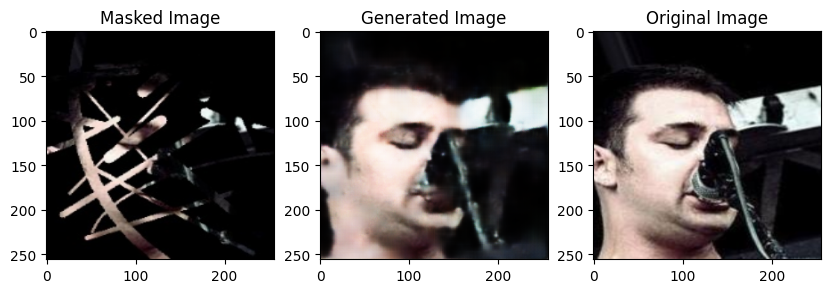

In [ ]:
import matplotlib.pyplot as plt

def show_images(masked, generated, real):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    axes[0].imshow(masked.permute(1, 2, 0).cpu().detach().numpy() * 0.5 + 0.5)
    axes[0].set_title("Masked Image")

    axes[1].imshow(generated.permute(1, 2, 0).cpu().detach().numpy() * 0.5 + 0.5)
    axes[1].set_title("Generated Image")

    axes[2].imshow(real.permute(1, 2, 0).cpu().detach().numpy() * 0.5 + 0.5)
    axes[2].set_title("Original Image")

    plt.show()

masked, real = next(iter(dataloader))
masked = masked.to(device)
generated = generator(masked)
show_images(masked[0], generated[0], real[0])


In [ ]:
dataloader = DataLoader(dataset, batch_size=10, shuffle=False)



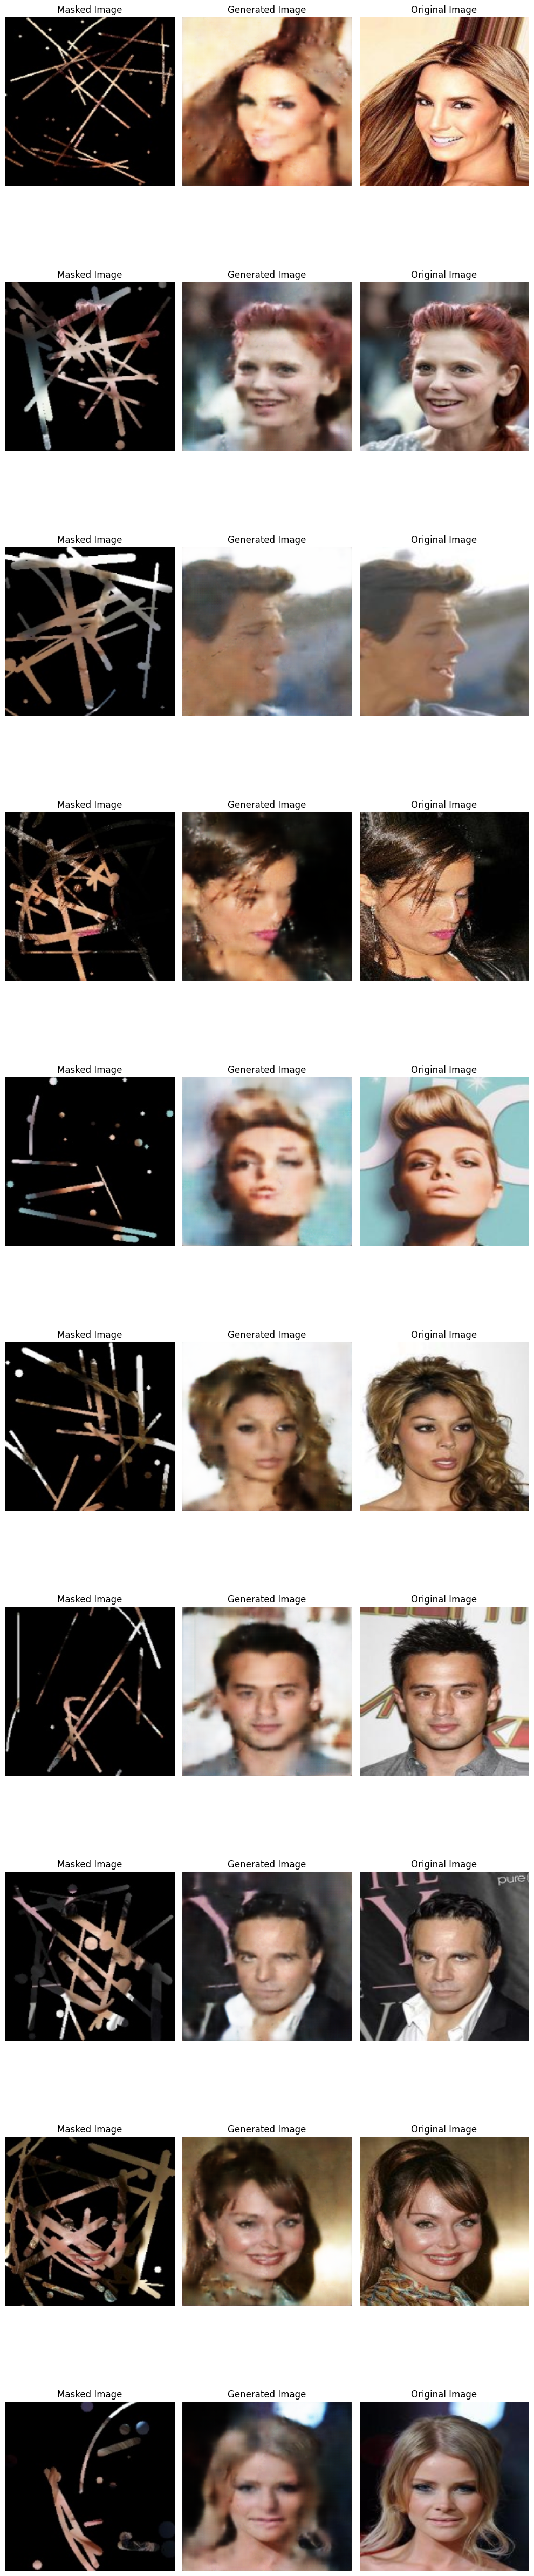

In [ ]:
import matplotlib.pyplot as plt

def show_images(masked_batch, generated_batch, real_batch, num_images=10):
    # Get the actual number of images in the batch (to avoid out of bounds error)
    num_images = min(num_images, masked_batch.shape[0])  # Use the smaller of 10 or the batch size

    # Create subplots for each image in the batch (three columns: masked, generated, real)
    fig, axes = plt.subplots(num_images, 3, figsize=(10, 5 * num_images))

    for i in range(num_images):
        # Display masked image
        axes[i, 0].imshow(masked_batch[i].permute(1, 2, 0).cpu().detach().numpy() * 0.5 + 0.5)
        axes[i, 0].set_title("Masked Image")
        axes[i, 0].axis("off")

        # Display generated image
        axes[i, 1].imshow(generated_batch[i].permute(1, 2, 0).cpu().detach().numpy() * 0.5 + 0.5)
        axes[i, 1].set_title("Generated Image")
        axes[i, 1].axis("off")

        # Display real image
        axes[i, 2].imshow(real_batch[i].permute(1, 2, 0).cpu().detach().numpy() * 0.5 + 0.5)
        axes[i, 2].set_title("Original Image")
        axes[i, 2].axis("off")

    # Adjust layout to prevent overlap and show the plot
    plt.tight_layout()
    plt.show()

# Assuming `dataloader` provides the batch and `device` is set to your computation device (CPU/GPU)
masked_batch, real_batch = next(iter(dataloader))  # Load a batch of images
masked_batch = masked_batch.to(device)  # Move masked batch to device

# Generate images using the generator (assuming it's loaded and available)
generated_batch = generator(masked_batch)

# Display the first 10 images in the batch (masked, generated, and original)
show_images(masked_batch, generated_batch, real_batch, num_images=10)



In [ ]:
torch.save(generator.state_dict(), "pix2pix_generator.pth")
torch.save(discriminator.state_dict(), "pix2pix_discriminator.pth")


In [ ]:
torch.save({
    'epoch': num_epochs,
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'optimizer_G_state_dict': optimizer_G.state_dict(),
    'optimizer_D_state_dict': optimizer_D.state_dict(),
    'g_losses': g_losses,
    'd_losses': d_losses
}, "pix2pix_checkpoint.pth")



In [ ]:
generator.load_state_dict(torch.load("pix2pix_generator.pth", map_location=device))
generator.eval()  # Set to evaluation mode


NameError: name 'generator' is not defined

In [ ]:
from PIL import Image
import torchvision.transforms as transforms
import torch

# Define image transformations (resize as needed)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor (scales pixel values to [0,1])
    transforms.Resize((256, 256)),  # Resize if needed (match training size)
])

# Load a test image (provide actual path)
test_image_path = "/content/drive/MyDrive/FINAL PROJECT/REAL IMAGES/000002.jpg"  # Update with your test image path
test_image = Image.open(test_image_path).convert("RGB")  # Ensure RGB format

# Apply transformations
test_image = transform(test_image)  # Convert to tensor
test_image = test_image.unsqueeze(0)  # Add batch dimension

# Move to device (CPU/GPU)
test_image = test_image.to(device)

print("Test image shape:", test_image.shape)  # Should be [1, 3, H, W]



Test image shape: torch.Size([1, 3, 256, 256])


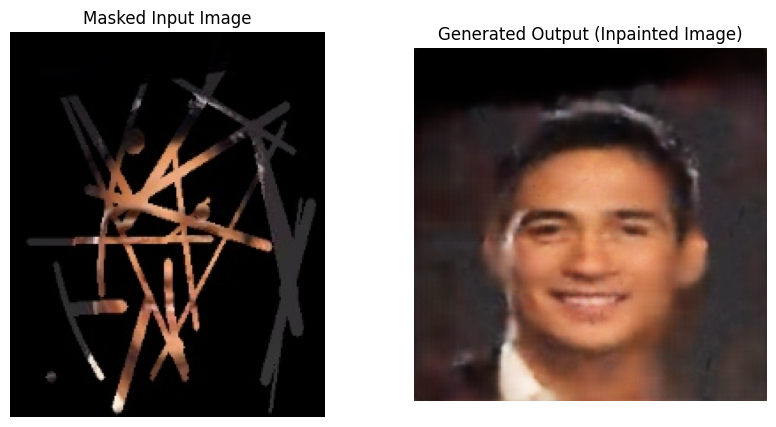

In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

# Function to preprocess input image
def preprocess_image(image_path, device, image_size=(256, 256)):
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1] range
    ])
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    return image, image_tensor  # Return both original PIL image and tensor

# Function to generate inpainted image
def generate_inpainted_image(masked_image_path, generator, device):
    generator.eval()  # Set model to evaluation mode
    original_image, masked_tensor = preprocess_image(masked_image_path, device)

    # Generate inpainted image
    with torch.no_grad():
        generated_tensor = generator(masked_tensor).cpu()  # Move to CPU

    # Convert tensors back to images
    to_pil = transforms.ToPILImage()
    generated_image = to_pil((generated_tensor.squeeze(0) * 0.5 + 0.5).clamp(0, 1))  # Denormalize and clamp

    return original_image, generated_image

# Function to display images
def display_results(masked_image_path, generator, device):
    original_image, generated_image = generate_inpainted_image(masked_image_path, generator, device)

    # Display images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(Image.open(masked_image_path))
    plt.title("Masked Input Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(generated_image)
    plt.title("Generated Output (Inpainted Image)")
    plt.axis("off")

    plt.show()

# Example usage:
masked_image_path = "/content/drive/MyDrive/FINAL PROJECT/masked_images/000012.jpg"  # Replace with your masked image path
display_results(masked_image_path, generator, device)


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np

def calculate_psnr(original, generated):
    """
    Compute the PSNR (Peak Signal-to-Noise Ratio) between original and generated images.

    Args:
        original (torch.Tensor): Ground truth image tensor (C, H, W) in range [0, 1]
        generated (torch.Tensor): Generated image tensor (C, H, W) in range [0, 1]

    Returns:
        float: PSNR value in dB.
    """
    mse = F.mse_loss(original, generated)  # Compute Mean Squared Error
    if mse == 0:
        return float('inf')  # Avoid division by zero
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))  # PSNR Formula
    return psnr.item()  # Convert to float

# Example Usage
original_img = real_batch[0].to(device)  # Ground truth image (first image in batch)
generated_img = generated_batch[0].to(device)  # Generated image (first image in batch)

psnr_value = calculate_psnr(original_img, generated_img)
print(f"PSNR Score: {psnr_value:.2f} dB")


PSNR Score: 12.17 dB


In [ ]:
import torch
import numpy as np
from skimage.metrics import structural_similarity as ssim

def calculate_ssim(generated_batch, real_batch):
    """
    Compute SSIM (Structural Similarity Index Measure) between generated and real images.

    Args:
        generated_batch (Tensor): Generated images (B, C, H, W).
        real_batch (Tensor): Real images (B, C, H, W).

    Returns:
        float: Average SSIM over the batch.
    """
    batch_size = generated_batch.shape[0]

    # Ensure images are in [0,1] range before computing SSIM
    generated_batch = (generated_batch * 0.5) + 0.5  # Convert from [-1,1] to [0,1]
    real_batch = (real_batch * 0.5) + 0.5  # Convert from [-1,1] to [0,1]

    # Compute SSIM for each image
    avg_ssim = 0
    for i in range(batch_size):
        gen_img_np = generated_batch[i].permute(1, 2, 0).cpu().numpy()  # Convert to (H, W, C)
        real_img_np = real_batch[i].permute(1, 2, 0).cpu().numpy()

        # Compute SSIM with a valid window size (smallest odd number ≤ min dimension)
        min_dim = min(real_img_np.shape[:2])
        win_size = min(7, min_dim if min_dim % 2 != 0 else min_dim - 1)

        avg_ssim += ssim(real_img_np, gen_img_np, data_range=1.0, win_size=win_size, channel_axis=-1)

    avg_ssim /= batch_size  # Compute average SSIM

    return avg_ssim

# Generate images using the model
with torch.no_grad():
    generated_batch = generator(masked_batch)  # Get generated images
    generated_batch = generated_batch.to(device)  # Move to device if needed

# Compute SSIM
ssim_value = calculate_ssim(generated_batch, real_batch)

print(f"Average SSIM: {ssim_value:.4f}")


Average SSIM: 0.2588
